In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# Constants
MHz = 10**6
GHz = 10**9
km = 10**3

In [3]:
# Processing the data
filename = "data.txt"
with open(filename, 'r') as file:
    text = file.read()
data = text.split("\n")

distances = []
freqs = []
powers = []
carriers = []
for i in range(1,len(data)-1):
    txt = data[i].split("|")
    if txt[0] == "" or txt[1] == "" or txt[2] == "" or txt[3] == "" or txt[4] == "" or txt[5] == "":
        continue
    distances.append(float(txt[0]))
    freqs.append(float(txt[1]))
    powers.append(float(txt[3]))
    carriers.append(txt[5])

df = pd.DataFrame(data=carriers,columns=['provider'])
df['distance'] = distances
df['frequency'] = freqs
df['power'] = powers
df = df.drop(index=df[df['distance']==0].index)

# Removing the outliers (due to the power being too low)
df = df[df['power']>-800]

In [4]:
frequency_ranges = np.array([0,10, 20,30,40,70,80,90],dtype='float64')*10**9
frequency_labels = ['< 10', '10 - 20', '20 - 30', '30 - 40',  '40 - 70', '70 - 80', '80 - 90']
df['frequency_range'] = pd.cut(df['frequency'], frequency_ranges, labels=frequency_labels)
df['wave_length'] = 3*10**8/df['frequency']

In [5]:
kpn = df[df['provider']=='kpn']
tmobile = df[df['provider']=='t-mobile']
vodafone = df[df['provider']=='vodafone']
prorail = df[df['provider']=='prorail']
tele2 = df[df['provider']=='tele2']
unknown = df[df['provider']=='unknown']
NA = df[df['provider']=='N/A']

In [6]:
# Only considering main providers
df = pd.concat([kpn,vodafone,tmobile,prorail],axis=0)
#df.to_csv('my_dataframe.csv', index=False)

In [7]:
print("Number of KPN links: " , len(kpn)) 
print("Number of T-Mobile links: " , len(tmobile)) 
print("Number of Vodafone links: " , len(vodafone)) 
print("Number of Prorail links: " , len(prorail)) 
print("Number of Tele2 links: " , len(tele2)) 
print("Number of unknown links: " , len(unknown)+len(NA)) 

Number of KPN links:  1387
Number of T-Mobile links:  7978
Number of Vodafone links:  4855
Number of Prorail links:  309
Number of Tele2 links:  2
Number of unknown links:  2894


## RQ-1: How are distribution of frequencies for different providers?

In [8]:
providers_name =['KPN','Prorail','T-Mobile','Vodafone']

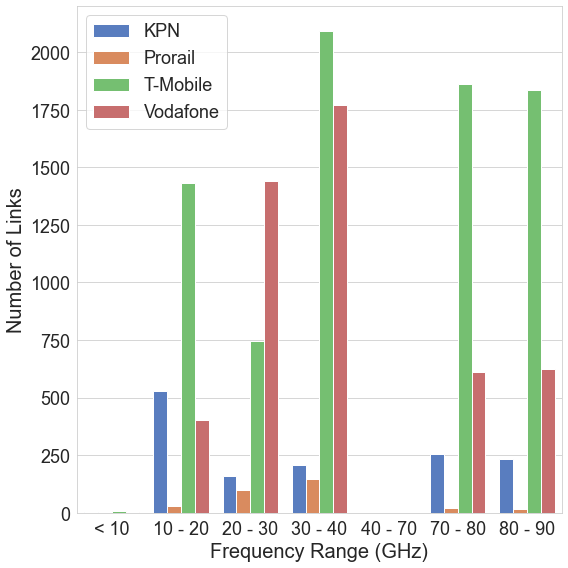

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(8, 8))
sns.set_style("whitegrid")
frequency_distribution = df.groupby(['provider', 'frequency_range']).size().reset_index(name='count')


ax = sns.barplot(x="frequency_range", y="count", hue="provider", data=frequency_distribution, palette="muted", ci=None)
ax.set_xlabel('Frequency Range (GHz)',fontsize=20)
ax.set_ylabel('Number of Links',fontsize=20)
ax.legend(labels=providers_name,fontsize=18,loc="upper left")
ax.tick_params(labelsize=18)

plt.tight_layout()
plt.savefig("frequency.pdf", dpi=900, bbox_inches='tight')
plt.show()

## RQ-2: How is the distances of the links distributed?

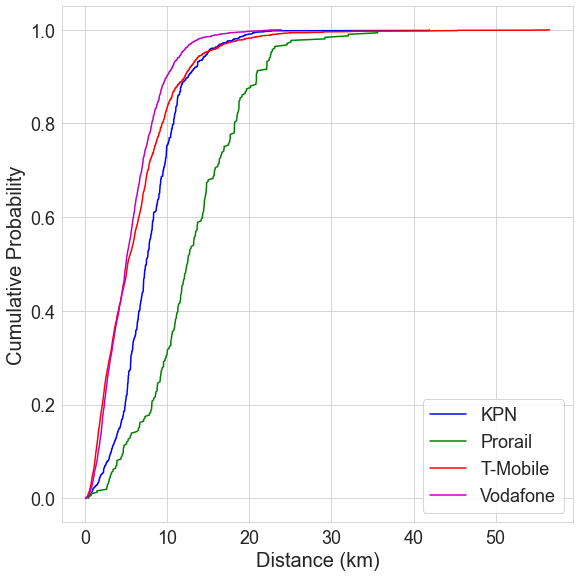

In [10]:
def compute_cdf(data):
    sorted_data = np.sort(data)
    yvals = np.arange(len(sorted_data)) / float(len(sorted_data))
    return sorted_data, yvals


colors = ['b', 'g', 'r', 'm']
plt.figure(figsize=(8, 8))

i = 0
for provider, color in zip(providers_name, colors):
    data = df[df['provider'] == provider.lower()]['distance']
    data = data/1000
    xvals, yvals = compute_cdf(data)
    plt.plot(xvals, yvals, color=color, label=providers_name[i])
    i = i + 1

plt.xlabel('Distance (km)',fontsize=20)
plt.ylabel('Cumulative Probability',fontsize=20)
plt.legend(fontsize=18)
plt.grid(True)
plt.tight_layout()
plt.tick_params(labelsize=18)
plt.savefig("distance.pdf", dpi=900, bbox_inches='tight')
plt.show()

## RQ-3: How is the relation between Radio Frequency and Link Length?

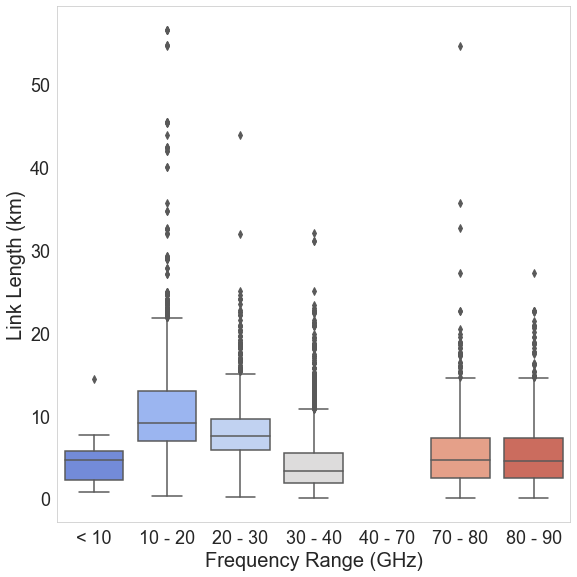

In [11]:
df['distance_km'] = df['distance'] / 1000


ordered_frequency_ranges = ['< 10', '10 - 20', '20 - 30', '30 - 40', '40 - 70', '70 - 80', '80 - 90']


plt.figure(figsize=(8, 8))
sns.boxplot(x='frequency_range', y='distance_km', data=df, palette="coolwarm", order=ordered_frequency_ranges)
plt.ylabel('Link Length (km)',fontsize=20)
plt.xlabel('Frequency Range (GHz)',fontsize=20)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.tick_params(labelsize=18)
plt.savefig("distance_freq.pdf", dpi=900, bbox_inches='tight') 
plt.show()

## RQ-4: Impact of Rainfall on Backhaul Communication Links

In [12]:
# Assumptions
path_loss_exponent = 2
bandwidth = 0.1*GHz
T = 300 # Temp. in Kelvin
receiver_antenna_gain = 18 # dBW

In [13]:
df['FSPL'] = 92.4 + 20*np.log10(df['frequency']/GHz) + 10*path_loss_exponent*np.log10(df['distance']/km)

In [14]:
noise_watt = 1.38*10**-23*T*bandwidth
noise_DB = 10*np.log10(noise_watt)


In [15]:
df['received_signal_power_db'] = df['power']-df['FSPL']+receiver_antenna_gain  
df['SNR_db'] = (df['received_signal_power_db']-noise_DB)
df['SNR'] = np.power(10,df['SNR_db']/10)
df['capacity'] = bandwidth*np.log2(1+ df['SNR'])
df['capacity_MB'] = df['capacity']/(1024*1024)

In [16]:
light_rain = 2
moderate_rain = 5
heavy_rain = 10
extreme_rain = 20
rain_rates = [light_rain, moderate_rain, heavy_rain, extreme_rain]

In [17]:
# Reading the rain coefficients, extracted from ITU Recommendation ITU-R P.838-3
filename = "rain_coefficients.txt"
with open(filename, 'r') as file:
    text = file.read()
data = text.split("\n")

rain_parameters = {} # k_H , alpha_H , k_V, alpha_V

for i in range(int((len(data)-3)/5)):
    frequency = float(data[3 + 5*i])
    rain_parameters[frequency] = [float(data[3 + 5*i + 1] ),float(data[3 + 5*i + 2] ),float(data[3 + 5*i + 3] ),float(data[3 + 5*i + 4] )]

df['k_V'] = 0
df['alpha_V'] = 0
frequencies_in_table = np.array(list(rain_parameters.keys()))

for i in df.index:
    f = df.loc[i]['frequency']/GHz
    band = frequencies_in_table[np.argmin(np.abs(frequencies_in_table-f))]
    df.loc[i,('k_V')] = rain_parameters[band][2]
    df.loc[i,('alpha_V')] = rain_parameters[band][3]

In [18]:
for r in rain_rates:
    df['rain_attenuation_'+str(r)] = df['k_V']*np.power(r,df['alpha_V'])*(df['distance']/km)
    df['SNR_db_after_rain_'+str(r)] = df['SNR_db']-df['rain_attenuation_'+str(r)]
    df['capacity_after_rain_'+str(r)] = bandwidth*np.log2(1+ np.power(10,df['SNR_db_after_rain_'+str(r)]/10))
    df['capacity_MB_after_rain_'+str(r)] = df['capacity_after_rain_'+str(r)]/(1024*1024)

In [19]:
# save the dataframe
df.to_csv('impact_of_rain.csv', index=False)

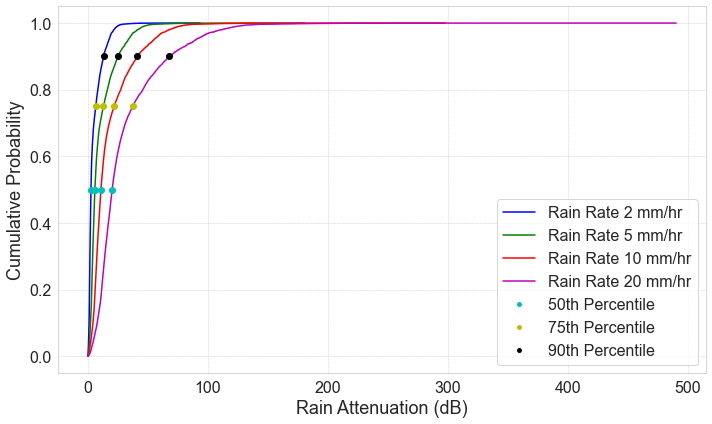

In [20]:
columns = [f"rain_attenuation_{rate}" for rate in rain_rates]
distinct_colors = ['b', 'g', 'r', 'm']
marker_colors = ['c', 'y', 'k']

probs = [0.5, 0.75, 0.9]

handles = []
labels = []

plt.figure(figsize=(10, 6))

for column, rate, color in zip(columns, rain_rates, distinct_colors):
    sorted_data = np.sort(df[column])
    yvals = np.arange(len(sorted_data)) / float(len(sorted_data))
    line, = plt.plot(sorted_data, yvals, label=f"Rain Rate {rate} mm/hr", color=color)
 
    handles.append(line)
    labels.append(f"Rain Rate {rate} mm/hr")
    
    for p, m_color in zip(probs, marker_colors):
        x_val = np.interp(p, yvals, sorted_data)
        plt.plot(x_val, p, 'o', color=m_color)


for p, m_color in zip(probs, marker_colors):
    handles.append(plt.Line2D([0], [0], color='w', markerfacecolor=m_color, marker='o'))
    labels.append(f"{int(p*100)}th Percentile")


plt.xlabel("Rain Attenuation (dB)", fontsize=18)
plt.ylabel("Cumulative Probability",    fontsize=18)
plt.legend(handles=handles, labels=labels, fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tick_params(labelsize=16)
plt.tight_layout()
plt.savefig("rain_attenuation.pdf", dpi=900, bbox_inches='tight')
plt.show()

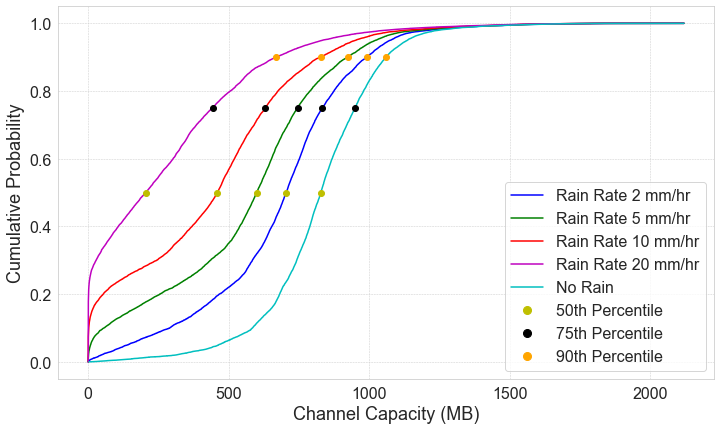

In [21]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

capacity_columns = [f"capacity_MB_after_rain_{rate}" for rate in rain_rates] + ["capacity_MB"]

curve_colors = ['b', 'g', 'r', 'm', 'c']
marker_colors = ['y', 'k', 'orange']

lines = [] 

plt.figure(figsize=(10, 6))
for column, color in zip(capacity_columns, curve_colors):
    sorted_data = np.sort(df[column])
    yvals = np.arange(len(sorted_data)) / float(len(sorted_data))
    
    if column == "capacity_MB":
        label = "No Rain"
    else:
        rate = column.split("_")[-1]
        label = f"Rain Rate {rate} mm/hr"
    line, = plt.plot(sorted_data, yvals, label=label, color=color)
    lines.append(line)
    
    idx_50 = find_nearest(yvals, 0.5)
    idx_75 = find_nearest(yvals, 0.75)
    idx_90 = find_nearest(yvals, 0.9)
    plt.plot(sorted_data[idx_50], yvals[idx_50], marker='o', color=marker_colors[0])
    plt.plot(sorted_data[idx_75], yvals[idx_75], marker='o', color=marker_colors[1])
    plt.plot(sorted_data[idx_90], yvals[idx_90], marker='o', color=marker_colors[2])

legend_handles_markers = [plt.Line2D([0], [0], marker='o', color=marker_colors[0], markersize=8, label='50th Percentile', linestyle='None'),
                          plt.Line2D([0], [0], marker='o', color=marker_colors[1], markersize=8, label='75th Percentile', linestyle='None'),
                          plt.Line2D([0], [0], marker='o', color=marker_colors[2], markersize=8, label='90th Percentile', linestyle='None')]

plt.legend(handles=lines + legend_handles_markers, loc='lower right', fontsize=16)

plt.xlabel("Channel Capacity (MB)",fontsize=18)
plt.ylabel("Cumulative Probability",    fontsize=18)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.tick_params(labelsize=16)
plt.savefig("capacity.pdf", dpi=900, bbox_inches='tight')
plt.show()